In [ ]:
# Poisson - Assumes a Poisson distribution, with variance equal to the mean.
# Well suited to:  How many of something will happen each period?
# Example:  How many complaints will happen per day?
#
# Negative Binomial.  Based on Poisson-gamma mixture distribution.
# Well suited to:  How many events will be in a certain category for each fixed sample size of events.
# Example:  How many of each 100 complaints will be a heating complaint?
#
# Zero-inflated Poisson
# Truncated Negative Binomial
#
# Exposure Variable.  The period or area of time in which the counts were generated.
# If "Offset Variable" instead, then need to take natural log of the variable.




#### <h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 4 of 4</p>

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 4
---

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

## Approach
Attempt to build a predictive model to predict heating complaints by using past data.
Assemble complaint data vs. time.
Graph it to get a sense of any patterns.
Build model.
Test model 

Determine relationship between number of complaints over time.
Establish regression model to calculate number of complaints for each day of the year.

Because the building data itself doesn't change over time, I will be looking for patterns in the number of complaints based essentially on time of year.  My hunch is that there will be more heating complaints in the winter.

## Load Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [3]:
# Only load the NY 311 data for this question.
df = pd.read_pickle(files_path + 'ny311full.pkl')
print("Shape of initial data %s" % (df.shape,))

Shape of initial data (5862383, 15)


<a id="wrangling"></a>
# Data Cleaning and Standardization
---

### General

In [4]:
# Remove features deemed unnecessary for this question.
df.drop(['street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude','incident_zip','incident_address','city','borough'], axis=1, inplace=True)
print("Shape after first feature culling %s" % (df.shape,))

Shape after first feature culling (5862383, 2)


In [5]:
# Only use the combined "heating and hot water" type of observations determined from Question 1.
df['complaint_type'] = df['complaint_type'].str.upper()
df.drop(df[df["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==False].index, axis=0, inplace=True)
# The complaint type is only used for filtering observations this time.
df.drop(['complaint_type'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Shape after row culling based on complaint type %s" % (df.shape,))

Shape after row culling based on complaint type (2040461, 1)


In [6]:
# Data types
df.dtypes

created_date    object
dtype: object

In [7]:
# Convert the date into actual datetime type.
df['created_date'] = pd.to_datetime(df['created_date'])
df.dtypes

created_date    datetime64[ns]
dtype: object

In [8]:
# Nulls
df.isnull().sum()

created_date    0
dtype: int64

In [9]:
# Check ranges
df.describe()

,created_date
count,2040461
unique,855540
top,2013-01-24 00:00:00
freq,5847
first,2010-01-01 00:00:00
last,2019-09-28 23:48:12


## Latent variables
Derived from the other data

### Break the created_date into latent variables for year and day of year.

In [10]:
# Break the created_date into latent variables for year and day of year.
df['Year'] = df['created_date'].dt.year
df['DayOfYear'] = df['created_date'].dt.dayofyear

### Structure the data into total complaints per day.

In [11]:
totals = df.groupby(['Year','DayOfYear']).size()
totals = pd.DataFrame(totals)
totals.reset_index(inplace=True)
totals.columns=['Year','DayOfYear','Complaints']
totals.head()

,Year,DayOfYear,Complaints
0,2010,1,770
1,2010,2,1457
2,2010,3,2785
3,2010,4,2740
4,2010,5,2036


In [12]:
# See ranges
min = df['Year'].min()
max = df['Year'].max()
print(min, max)

2010 2019


## Analyze including Visualizations

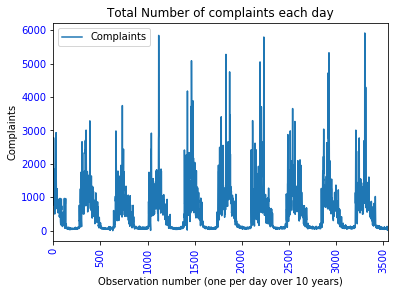

In [24]:
# Basic visualization
totals[['Complaints']].plot(title="Total Number of complaints each day")
plt.xticks(rotation=90,color='blue')
plt.yticks(color='blue')
plt.ylabel("Complaints")
plt.xlabel("Observation number (one per day over 10 years)")
plt.show()

<p style="color:Red;"><b>Observation:</b>  There appears to be a general recurring U pattern each year.  Presumably heating complaints higher in the winter months.</p>

In [14]:
# Given the curves, a linear regression seems unlikely, but try it anyway just to confirm.
lm=LinearRegression()
X = totals[['DayOfYear']]
Y = totals[['Complaints']]
lm.fit(X,Y)
Yhat=lm.predict(X)

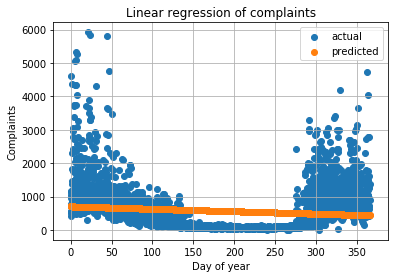

In [15]:
plt.title("Linear regression of complaints")
plt.scatter(X, Y, label="actual")
plt.scatter(X, Yhat, label="predicted")
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Complaints')
plt.grid()
plt.show()

<p style="color:Red;">As expected a simple linear model does not fit the data well.</p>

<p style="color:Red;">The parabolic U shape of the data suggests a Non-Linear quadratic function.  But it is a count, not strictly a continuous value, so I will attempt Poisson Regression first.</p>

### Poisson Regression
Supposedly suitable for predicting "count" based values.  I will try it on the complaint count.

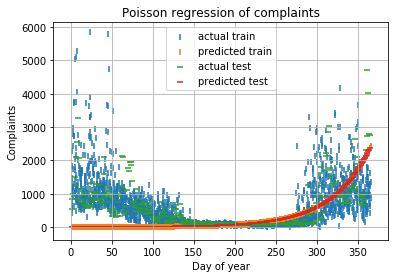

Train
  Mean squared error:  606004.5569782053
  R-squared:  -0.3033939740727585
Test
  Mean squared error:  458733.61873572116
  R-squared:  0.01831435129448944


In [16]:
# Try Poisson regression
Xtrain = totals[totals['Year'].lt(2017)][['DayOfYear']]
Ytrain = totals[totals['Year'].lt(2017)][['Complaints']]
Xtest = totals[totals['Year'].eq(2017)][['DayOfYear']]
Ytest = totals[totals['Year'].eq(2017)][['Complaints']]

poisson_model = sm.GLM(Ytrain, Xtrain, family=sm.families.Poisson())
fitted_model = poisson_model.fit()

poisson_predictions = fitted_model.get_prediction(Xtrain)
predictions_summary_frame = poisson_predictions.summary_frame() #.summary_frame() returns a pandas DataFrame
Y_hat_train = predictions_summary_frame['mean']

poisson_predictions = fitted_model.get_prediction(Xtest)
predictions_summary_frame = poisson_predictions.summary_frame()
Y_hat_test = predictions_summary_frame['mean']

plt.title("Poisson regression of complaints")
plt.scatter(Xtrain, Ytrain, label="actual train", marker ='|')
plt.scatter(Xtrain, Y_hat_train, label="predicted train", marker ='|')
plt.scatter(Xtest, Ytest, label="actual test", marker ='_')
plt.scatter(Xtest, Y_hat_test, label="predicted test", marker ='_')
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Complaints')
plt.grid()
plt.show()
print('Train')
print('  Mean squared error: ', mean_squared_error(Ytrain, Y_hat_train))
print('  R-squared: ', r2_score(Ytrain, Y_hat_train))
print('Test')
print('  Mean squared error: ', mean_squared_error(Ytest, Y_hat_test))
print('  R-squared: ', r2_score(Ytest, Y_hat_test))    

<p style="color:Red;">Maybe Poisson isn't suitable because we have only one feature (day of year) that is going in, so it can't model a parabolic shape?  Perhaps having the continuous number of each time interval itself as the only feature is the problem?</p>

### Polynomial Regression
The Non-Linear quadratic function for a parabolic shape is a degree two polynomial.  ax^2 + bx + c = 0.  So perhaps this will model the situation better.  Since I'm using only the counts that are non-zero, the complaint counts I have are perhaps a continuous enough value to not need to be treated strictly as a count.

In [26]:
# Function for visualizing or measuring different degree polynomials.
def poly(degrees, mode):
    # training data is years 2010-2017.  Test data is 2018 to present.
    Xtrain = totals[totals['Year'].lt(2018)][['DayOfYear']]
    Ytrain = totals[totals['Year'].lt(2018)][['Complaints']]
    Xtest = totals[totals['Year'].ge(2018)][['DayOfYear']]
    Ytest = totals[totals['Year'].ge(2018)][['Complaints']]
    lr = LinearRegression()
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=degrees, include_bias=False)), ('model',lr)]
    pipe=Pipeline(Input)
    pipe.fit(Xtrain,Ytrain)
    Y_hat_train =pipe.predict(Xtrain)
    Y_hat_test =pipe.predict(Xtest)
    train_r = r2_score(Ytrain, Y_hat_train)
    test_r = r2_score(Ytest, Y_hat_test)    
    if mode=="VISUALIZE":
        plt.title("Polynomial (degree " + str(degrees) + ") regression of complaints")
        plt.scatter(Xtrain, Ytrain, label="actual train", marker ='|')
        plt.scatter(Xtrain, Y_hat_train, label="predicted train", marker ='|')
        plt.scatter(Xtest, Ytest, label="actual test", marker ='_')
        plt.scatter(Xtest, Y_hat_test, label="predicted test", marker ='_')
        plt.legend()
        plt.xlabel('Day of year')
        plt.ylabel('Complaints')
        plt.grid()
        plt.show()
        print('Train')
        print('  Mean squared error: ', mean_squared_error(Ytrain, Y_hat_train))
        print('  R-squared: ', train_r)
        print('Test')
        print('  Mean squared error: ', mean_squared_error(Ytest, Y_hat_test))
        print('  R-squared: ', test_r)
        return
    if mode=="EQUATION":
        print(lr.coef_)
    return train_r, test_r

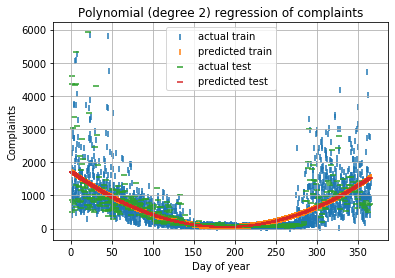

Train
  Mean squared error:  239448.3635704648
  R-squared:  0.4853279805904034
Test
  Mean squared error:  256707.44887881295
  R-squared:  0.4901294556765041


In [18]:
poly(2, "VISUALIZE")

<p style="color:Red;">Approximates the simple results in the summer well, but the prediction line seems "thin" for the winter.</p>

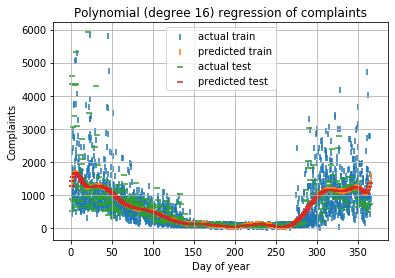

Train
  Mean squared error:  219381.39703654932
  R-squared:  0.5284600614926634
Test
  Mean squared error:  245486.26626481695
  R-squared:  0.512416890312078


In [19]:
poly(16, "VISUALIZE")

<p style="color:Red;">An even higher degree polynomial seems to better match the more chaotic results in the winter.  Error rate a bit lower.  The percentage the model matches the data (R-Squared) has improved.  But need to make sure it is not overfitted.</p>

### Polynomial Regression optimization
An attempt to determine the best performing degree before it over fits.

In [20]:
# Run through a series of degrees and measure the training and testing accuracy of each to detect where it overfits
measurements = pd.DataFrame(columns=['Degree', 'Train', 'Test'])
which_degree = 0
max = 0.0
for d in range(1,31,1):
    train, test = poly(d, "measure")
    if test > max:
        max = test
        which_degree = d
    measurements = measurements.append({'Degree':d, 'Train':train, 'Test':test}, ignore_index=True)
    #print("%i %.4f, %.4f" % (d, train, test))
measurements.head()

,Degree,Train,Test
0,1.0,0.006045,0.031207
1,2.0,0.485328,0.490129
2,3.0,0.485443,0.488635
3,4.0,0.493405,0.484839
4,5.0,0.500957,0.513099


In [28]:
print("Highest accuracy on test data %.4f the degree was %i" % (max, which_degree))
__,__ = poly(11,"EQUATION")

Highest accuracy on test data 0.5187 the degree was 11
[[  148.63568497   -41.19777465 -2198.47231778   618.70232274
   4109.98923367   146.68044912 -2859.89238577  -255.97026505
    852.09892161    52.34765592   -92.40624773]]


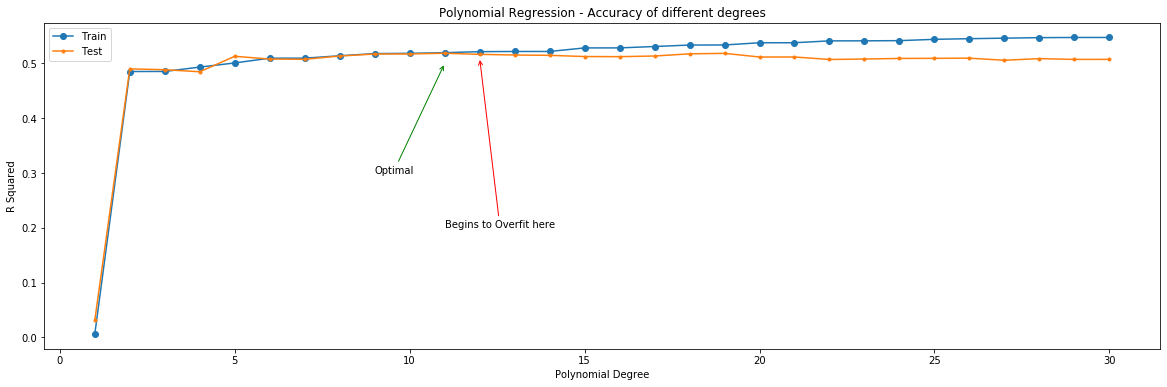

In [25]:
plt.figure(figsize=(20,6))
plt.title("Polynomial Regression - Accuracy of different degrees")
plt.plot(measurements['Degree'], measurements['Train'], label="Train", marker ='o')
plt.plot(measurements['Degree'], measurements['Test'], label="Test", marker ='.')
plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('R Squared')
plt.annotate("Begins to Overfit here", xy = (12,0.51), xycoords='data', xytext=(11,0.20), arrowprops=dict(arrowstyle= '->', color='red'))
plt.annotate("Optimal", xy = (11,0.50), xycoords='data', xytext=(9,0.30), arrowprops=dict(arrowstyle= '->', color='green'))

plt.show()

<p style="color:Red;">The most accurate predictive model appears to be an 11 degree polynomial based on the day of the year.</p>

<a id="conclusion"></a>
# Concluding Remarks
---

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

<b><u>Yes</u>, the HEATING/HOT WATER complaints (question 1) reported in the BRONX borough (question 2) have an obvious relationship with the housing characteristics.</b>  Some weak but distinct correlations:
<ul>
    <li><b><u>Building Type</u></b>.  Certain types are more or less prone to heating complaints than others:
    <ul>
        <li>Apartments!  <i>(Correlation:  0.43)</i>
        <ul>
            <li>Walk up apartments.  These are the most likely to have complaints.   <i>(Correlation:  0.34)</i>
            <li>Elevator apartments.  These are the second most likely to have complaints. <i>(Correlation:  0.26)</i>
        </ul>
        <li>One and two family homes.  These are <u>less</u> likely to have heating complaints than other building types.  <i>(Correlation:  -0.34 <u>negative</u>)</i>
    </ul>
    <li><b><u>Size</u></b>.  The larger the building, the more heating complaints.
    <ul>
        <li>Number of Floors.  <i>(Correlation:  0.27~0.37)</i>
        <li>Floor Area.  <i>(Correlation:  0.23~0.35)</i>
        <li>Building Depth.  <i>(Correlation:  0.17~0.26)</i>
    </ul>
</ul>
<u><b>Additional insights</b></u>:
<ul>
    <li>When there are complaints at elevator apartments it is much more likely there will be a <u>large number of complaints per address</u> with <i>0.28 correlation</i> compared to <i>only 0.07</i> for the walk up apartments.
    <li>The land use category 1 encompasses both single and two family homes.  Breaking them down by building class A and B, shows that single family homes contribute much more to the negative correlation to complaints <i>(-0.27)</i> than two family homes. <i>(-0.09)</i>
</ul>